In [1]:
#Mise en place de la dataframe Pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from fonctions import *
#Récupération des données
url = "https://equipements.sports.gouv.fr/api/explore/v2.1/catalog/datasets/data-es/records?select=inst_numero%2C%20inst_nom%2C%20dep_nom%2C%20dep_code_filled%2C%20new_code%2C%20new_name%2C%20inst_etat%2C%20%20inst_date_creation%2C%20inst_date_etat%2C%20inst_date_valid%2C%20inst_acc_handi_bool%2C%20%20inst_trans_bool%2C%20equip_numero%2C%20equip_nom%2C%20equip_type_code%2C%20%20equip_type_name%2C%20equip_type_famille%2C%20equip_x%2C%20equip_y%2C%20%20equip_etat%2C%20equip_eclair%2C%20equip_douche%2C%20equip_sanit%2C%20%20equip_pmr_aire%2C%20equip_pmr_douche%2C%20equip_pmr_sanit%2C%20%20equip_travaux_date%2C%20equip_service_date%2C%20equip_service_periode%2C%20equip_travaux_type%2C%20%20equip_energie%2C%20equip_prop_type%2C%20dens_lib%2C%20zrr_simp&limit=-1"
recensement = call_csv(url)
doublons = (recensement
            .groupby(['inst_nom', 'new_code'])
            .size()
            .reset_index(name='n')
            .query('n > 0'))

distinct = recensement.drop_duplicates(subset=['inst_nom', 'new_code'], keep='first')
df_es = pd.merge(distinct, doublons, on=['inst_nom', 'new_code'], how='outer')


df_es['equip_service_date'] = pd.to_numeric(df_es['equip_service_date'], errors='coerce') # Conversion de variable en float
df_es['equip_travaux_date'] = pd.to_numeric(df_es['equip_travaux_date'], errors='coerce') # Conversion de variable en float
dff = df_es.copy()
dff['equip_service_date'] = dff['equip_service_date'].fillna(0) # Remplacement des NaN par 0
dff['equip_travaux_date'] = dff['equip_travaux_date'].fillna(0) # Remplacement des NaN par 0

/home/onyxia/work/Python-data-science/fonctions.py:32: DtypeWarning: Columns (3,4,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('equipements_ile_de_france.csv', delimiter=';')


In [2]:
#Test
df = dff[dff['equip_service_date'] != 0]
df = df.copy()
df.count()

inst_numero              99489
inst_nom                 99489
dep_nom                  99486
dep_code_filled          99486
new_code                 99486
new_name                 99486
inst_etat                99489
inst_date_creation       99489
inst_date_etat           97901
inst_date_valid          97571
inst_acc_handi_bool      98190
inst_trans_bool          96513
equip_numero             99489
equip_nom                99489
equip_type_code          99466
equip_type_name          99466
equip_type_famille       99466
equip_x                  97578
equip_y                  97581
equip_etat               99489
equip_eclair             98494
equip_douche             96993
equip_sanit              98163
equip_pmr_aire           97903
equip_pmr_douche         20427
equip_pmr_sanit          83020
equip_travaux_date       99489
equip_service_date       99489
equip_service_periode    94865
equip_travaux_type       17889
equip_energie            31370
equip_prop_type          99123
dens_lib

In [3]:
# Conversion en bool des variables de qualité
df['equip_douche'] = (df['equip_douche'].astype(bool)).astype(int)
df['equip_sanit'] = (df['equip_sanit'].astype(bool)).astype(int)

In [4]:
# Variable représentant la dernière rénovation en date (equip_travaux_date vaut 0 s'il n'y a jamais eu de travaux)
df['derniere_renov'] = np.maximum(df['equip_travaux_date'], df['equip_service_date'])

In [5]:
# Min et max de la dernière rénovation
borne_min = df['derniere_renov'].min()
borne_max = df['derniere_renov'].max()

In [6]:
# Création des var. d'ancienneté
df['coef_recent'] = (df['derniere_renov'] - borne_min)/(borne_max - borne_min) # Coef. représentant l'ancienneté d'une infrastructure en comparaison aux autres de l'échantillon
df['récent'] = (df['derniere_renov']>=2011).astype(int)
df['moyen'] = ((df['derniere_renov']>=1986) & (df['derniere_renov']<2011)).astype(int)
df['ancien'] = ((df['derniere_renov'] >= borne_min) & (df['derniere_renov'] < 1986)).astype(int) 

In [7]:
#Test
variables_a_afficher = ['inst_numero', 'inst_nom', 'dep_nom', 'new_name', 'inst_date_creation', 'inst_acc_handi_bool', 'inst_trans_bool', 'equip_nom'
, 'equip_type_name', 'equip_douche', 'equip_sanit','equip_travaux_date',  'derniere_renov', 'coef_recent', 'récent', 'moyen', 'ancien']
ligne_1000 = df.iloc[1000][variables_a_afficher]
print(ligne_1000)

inst_numero                                          I782690007
inst_nom               AMCR ALBATROS MODELE CLUB DE RAMBOUILLET
dep_nom                                                Yvelines
new_name                                                Gazeran
inst_date_creation                                   2005-09-22
inst_acc_handi_bool                                       False
inst_trans_bool                                           False
equip_nom                                  AIRE D'AEROMODELISME
equip_type_name                            Site d'aéromodélisme
equip_douche                                                  0
equip_sanit                                                   0
equip_travaux_date                                          0.0
derniere_renov                                           1985.0
coef_recent                                             0.90099
récent                                                        0
moyen                                   

In [8]:
# Définition du coeff de vétusté
df['qualite'] = 0.8 * df['récent'] + 0.4 * df['moyen'] + 0.1 * df['equip_douche'] + 0.1 * df['equip_sanit']

In [ ]:
#Test
df.head(10)

,equip_nom,equip_service_date,equip_douche,equip_sanit,equip_travaux_date,derniere_renov,coef_recent,récent,moyen,ancien,qualite
1,TERRAIN DE TENNIS N°1,1976.0,1,1,0.0,1976.0,0.862745,0,0,1,0.2
2,COURTS DE TENNIS 8-9-10 2,1950.0,1,1,0.0,1950.0,0.789916,0,0,1,0.2
4,CITY STADE,2009.0,1,1,0.0,2009.0,0.955182,0,1,0,0.6
5,ESPACE COACHING,2013.0,1,1,0.0,2013.0,0.966387,1,0,0,1.0
6,Salle de renforcement musculaire,2023.0,1,1,0.0,2023.0,0.994398,1,0,0,1.0
7,Salle de biking,2023.0,1,1,0.0,2023.0,0.994398,1,0,0,1.0
8,SALLE RPM IMMERSIVE,1989.0,1,1,2014.0,2014.0,0.969188,1,0,0,1.0
9,1 COURT DE TENNIS,1992.0,1,1,0.0,1992.0,0.907563,0,1,0,0.6
10,SALLE DE DANSE,1996.0,1,1,2010.0,2010.0,0.957983,0,1,0,0.6
11,SALLE DE MUSCULATION CLUB,1994.0,1,1,0.0,1994.0,0.913165,0,1,0,0.6


In [10]:
# Calcul moyenne et médiane d'ancienneté
moyenne = df['coef_recent'].mean()
mediane = df['coef_recent'].median()
[moyenne, mediane]
# On voit qu'en IDF, les infrastructures sont très récentes :)

[np.float64(0.9169621849945941), np.float64(0.9299719887955182)]

In [9]:
# Ne conserver que les anciennetés inférieures à un certain seuil
df_filtre = df[df['coef_recent'] < 0.7]
df_filtre.head(20)

,inst_numero,inst_nom,dep_nom,dep_code_filled,new_code,new_name,inst_etat,inst_date_creation,inst_date_etat,inst_date_valid,...,equip_prop_type,dens_lib,zrr_simp,n,derniere_renov,coef_recent,récent,moyen,ancien,qualite
1837,I751120077,ARC CLUB PARIS 12,Paris,75,75112,Paris 12e Arrondissement,Validé,2005-09-22,2015-05-12,2015-05-12,...,Commune,Grands centres urbains,NaN,1.0,1884.0,0.650990,0,0,1,0.0
1887,I403150002,ARENES,Landes,40.0,40315.0,Téthieu,Validé,2005-12-11,2024-10-24,2024-10-24,...,Commune,Rural à habitat dispersé,NC - Commune non classée,3.0,1880.0,0.641089,0,0,1,0.1
2349,I940420010,AVIRON MARNE ET JOINVILLE (ILE FANAC),Val-de-Marne,94,94042,Joinville-le-Pont,Validé,2005-09-22,2018-06-05,2018-06-05,...,Commune,Grands centres urbains,NC - Commune non classée,1.0,1876.0,0.631188,0,0,1,0.2
2354,I690340004,AVIRON CLUB DE LYON CALUIRE,Rhône,69,69034,Caluire-et-Cuire,Attribué,2005-12-13,2018-02-12,2016-11-30,...,Association(s),Grands centres urbains,NC - Commune non classée,2.0,1882.0,0.646040,0,0,1,0.2
4815,I323440018,Arènes,Gers,32,32344,Riscle,Validé,2020-01-28,2020-01-28,2020-01-28,...,Commune,Bourgs ruraux,C - Classée en ZRR,1.0,1900.0,0.690594,0,0,1,0.2
6792,I784400022,BASSIN DE MEULAN,Yvelines,78,78440,Les Mureaux,Validé,2018-07-18,2018-07-24,2018-07-24,...,Association(s),Centres urbains intermédiaires,NC - Commune non classée,1.0,1902.0,0.695545,0,0,1,0.2
9515,I051320005,BOULODROME NON COUVERT,Hautes-Alpes,5,5132,Saint-Bonnet-en-Champsaur,Vérifié,2005-10-09,2019-07-17,2014-08-31,...,Commune,Bourgs ruraux,C - Classée en ZRR,1.0,1900.0,0.690594,0,0,1,0.1
11311,I070310009,Bois de Païolive,Ardèche,7.0,7031.0,Berrias-et-Casteljau,Validé,2005-06-27,2013-02-14,2013-02-14,...,Privé non commercial,Rural à habitat dispersé,C - Classée en ZRR,1.0,1900.0,0.690594,0,0,1,0.0
13278,I422180087,Boule de Chavassieux,Loire,42,42218,Saint-Étienne,Validé,2005-11-09,2023-12-12,2023-12-12,...,Commune,Grands centres urbains,NC - Commune non classée,1.0,1900.0,0.690594,0,0,1,0.1
13290,I422180042,Boule de la Croix de l'Orme,Loire,42,42218,Saint-Étienne,Validé,2005-11-20,2023-12-12,2023-12-12,...,Commune,Grands centres urbains,NC - Commune non classée,1.0,1903.0,0.698020,0,0,1,0.1


In [12]:
# equip_nom, equip_service_date, equip_douche, equip_sanit, equip_travaux_date

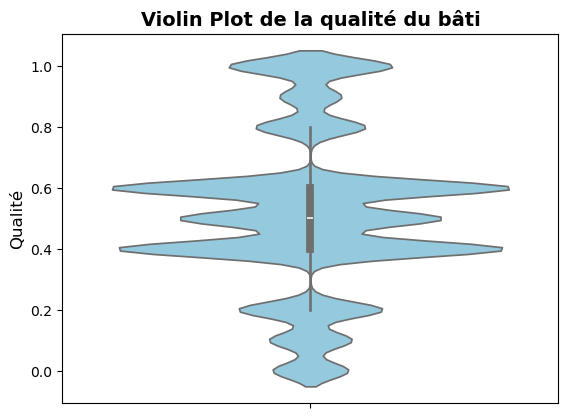

In [10]:
import seaborn as sns

# Exemple : violin plot pour la variable 'qualité'
sns.violinplot(data=df, y='qualite', color='skyblue')  # Ajuster "y" selon l'orientation
plt.title('Violin Plot de la qualité du bâti', fontsize=14, weight='bold')
plt.ylabel('Qualité', fontsize=12)
plt.show()

In [13]:
# Lien json
# https://equipements.sports.gouv.fr/api/explore/v2.1/catalog/datasets/data-es/exports/json?lang=fr&timezone=Europe%2FParis&select=equip_nom%2C%20equip_service_date%2C%20equip_douche%2C%20equip_sanit%2C%20equip_travaux_date&where=reg_nom%20like%20%27%C3%8Ele-de-France%27

# Lien CSV
# https://equipements.sports.gouv.fr/api/explore/v2.1/catalog/datasets/data-es/exports/csv?lang=fr&timezone=Europe%2FParis&use_labels=true&delimiter=%3B&select=equip_nom%2C%20equip_service_date%2C%20equip_douche%2C%20equip_sanit%2C%20equip_travaux_date&where=reg_nom%20like%20%27%C3%8Ele-de-France%27